In [1]:
# Import graphics related libraries
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')


from IPython.display import Image
from IPython import display
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# other libraries
import numpy as np
import scipy as sp
import pandas as pd
import simplejson
import sys
import requests
import sqlite3
from collections import Counter
import heapq

/Users/yinagu/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Location

conn = sqlite3.connect('/Users/yinagu/pokemon.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT from_user_location FROM hashtags WHERE from_user_location IS NOT NULL''')
counter = Counter()
count = 0
for row in cur:
    #if count>200: break
    # extract string from column 'from_user_location'
    location = str(row).strip()[3:-3].lower() 
    
    if len(location)!=0:
        counter[location] +=1
        count +=1
df_loc = pd.DataFrame(heapq.nlargest(1000, counter.items(), key=lambda x:x[1]), 
                  columns=['location','count'])
print('There are total of %d tweets having locataion entries.' %(count))

There are total of 123102 tweets having locataion entries.


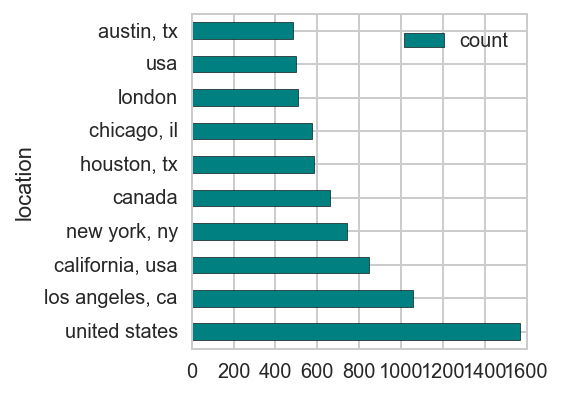

In [3]:
# Plot top 10 locations with highest number of tweets
df_loc.loc[0:9,:].plot(x='location', y='count', kind='barh', color='teal', figsize=(3,3))

In [3]:
# geocoding and add to dataframe
import codecs

# open an encoded file using utf-8 mode
fhand = codecs.open('where.js','w', "utf-8")
fhand.write("myData = [\n")
count = 0
url = 'https://maps.googleapis.com/maps/api/geocode/json'
for k, loc in enumerate(df_loc['location']):
    params = {'sensor':'false','address': loc}
    r = requests.get(url, params=params)
    results = r.json()['results']
    if len(results)==0: pass
    else:
        location = results[0]['geometry']['location']
        lat = location['lat']
        lng = location['lng']
        address = loc.replace("'","")
        df_loc.loc[k,'geocode']=str(lat)+','+str(lng)
        count+=1
        if count > 1 : fhand.write(",\n")
        output = "["+str(lat)+","+str(lng)+", '"+address+"']"
        fhand.write(output)
fhand.write("\n];\n")
fhand.close()

print "Wrote 'where.js'. Check 'where.html'"

Wrote 'where.js'. Check 'where.html'


In [5]:
# Take a look at data
df_loc.head()

,location,count,geocode
0,united states,1569,"37.09024,-95.712891"
1,"los angeles, ca",1057,"34.0522342,-118.2436849"
2,"california, usa",845,"36.778261,-119.4179324"
3,"new york, ny",741,"40.7127837,-74.0059413"
4,canada,661,"56.130366,-106.346771"


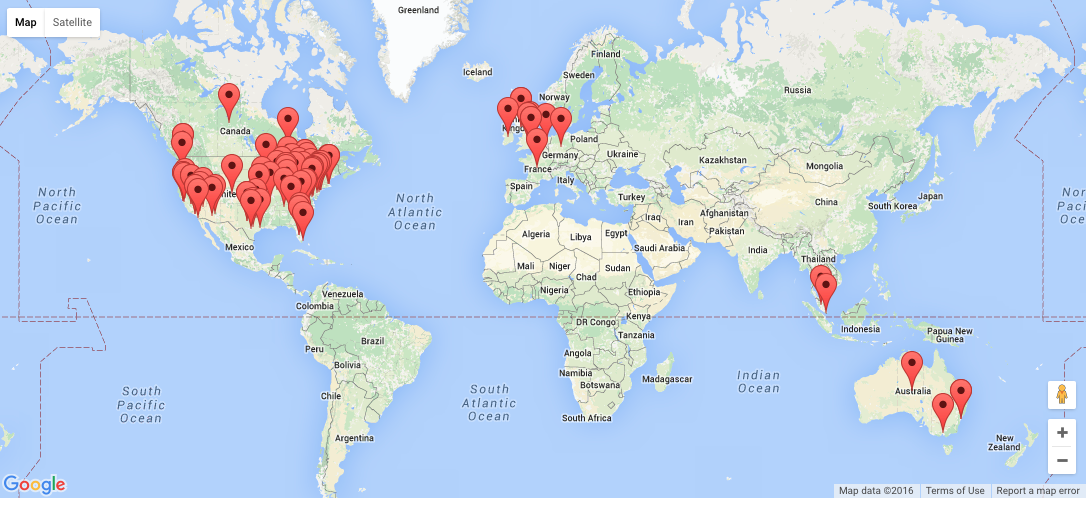

In [6]:
# display top 100 locations geolocation on google map
#Image(url="file:///Users/yinagu/Dropbox/dataIncubator/PokemonGo/where.html")
Image(filename="map_top100.png")

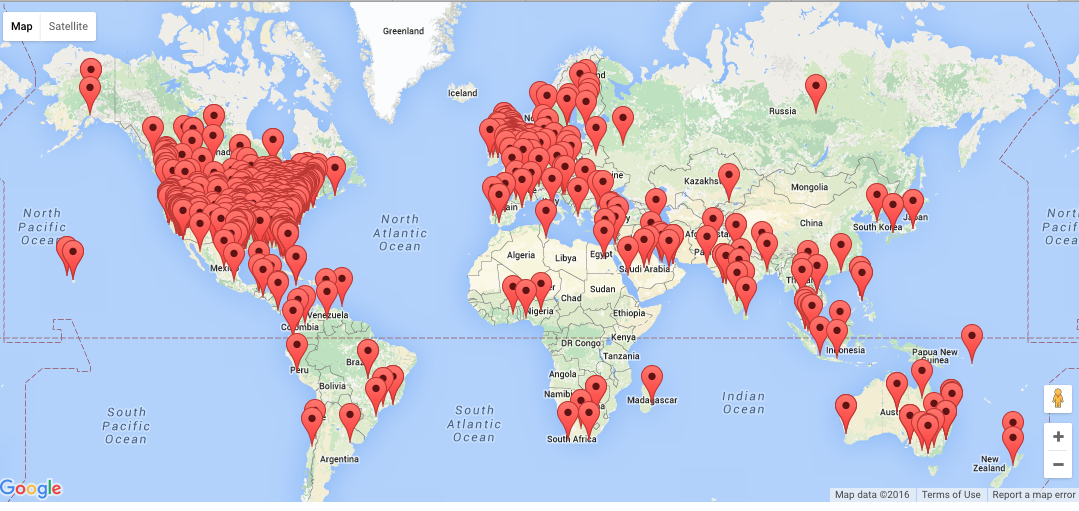

In [7]:
Image(filename="map_top1000.png")

In [4]:
# Zoom in US
US_box = [24.94, -125, 49.59, -66.93]
for k, loc in enumerate(df_loc.geocode):
    latlng = [float(x) for x in str(loc).split(',')]
    if (latlng[0] > US_box[0] and latlng[0] < US_box[2] and
        latlng[1] > US_box[1] and latlng[1] < US_box[3]):
        df_loc.loc[k,'US'] = 'US'
    else:
        df_loc.loc[k,'US'] = 'others'


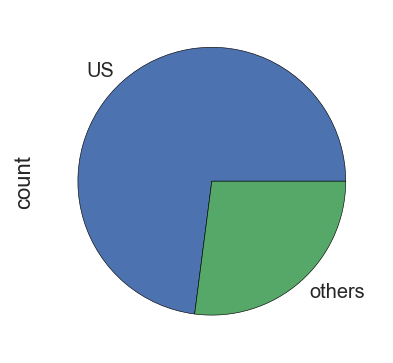

In [5]:
# What percent of US player?
df_loc.groupby('US')['count'].sum().plot.pie(figsize=(3,3))

In [6]:
df_loc.groupby('US')['count'].sum()

US
US        39761
others    14739
Name: count, dtype: int64

In [11]:
# Which states have the most tweets?
df_US = df_loc.loc[df_loc['US'] == 'US']
df_US.head()

,location,count,geocode,US
0,united states,1569,"37.09024,-95.712891",US
1,"los angeles, ca",1057,"34.0522342,-118.2436849",US
2,"california, usa",845,"36.778261,-119.4179324",US
3,"new york, ny",741,"40.7127837,-74.0059413",US
5,"houston, tx",585,"29.7604267,-95.3698028",US


In [12]:
# From wikipedia load state name table
state_url="https://simple.wikipedia.org/wiki/List_of_U.S._states"
df_list = pd.io.html.read_html(state_url)
df_state = df_list[0]
df_state.columns=df_state.ix[0]
df_state.drop(0, axis=0, inplace=True)
df_state.drop(['Capital', 'Became a State'], axis=1, inplace=True)
df_state['Abbreviation'] = [a.lower() for a in df_state['Abbreviation']]
df_state['State Name'] = [a.lower() for a in df_state['State Name']]
df_state.head()

,Abbreviation,State Name
1,al,alabama
2,ak,alaska
3,az,arizona
4,ar,arkansas
5,ca,california


In [13]:
def findstate(phrase):
    try:
        return list(df_state.loc[(df_state['Abbreviation'] == phrase)|
                     (df_state['State Name'] == phrase)]['Abbreviation'])[0]
    except:
        return 'NaN'

# group tweet counts by state
for k, row in zip(df_US.index, df_US.location):
    phrases = row.split(',')
    for phrase in phrases:
        st = findstate(phrase.strip())
        if st !='NaN': break    
    #print k, st
    df_US.US.ix[k] = st.upper()

/Users/yinagu/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/yinagu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


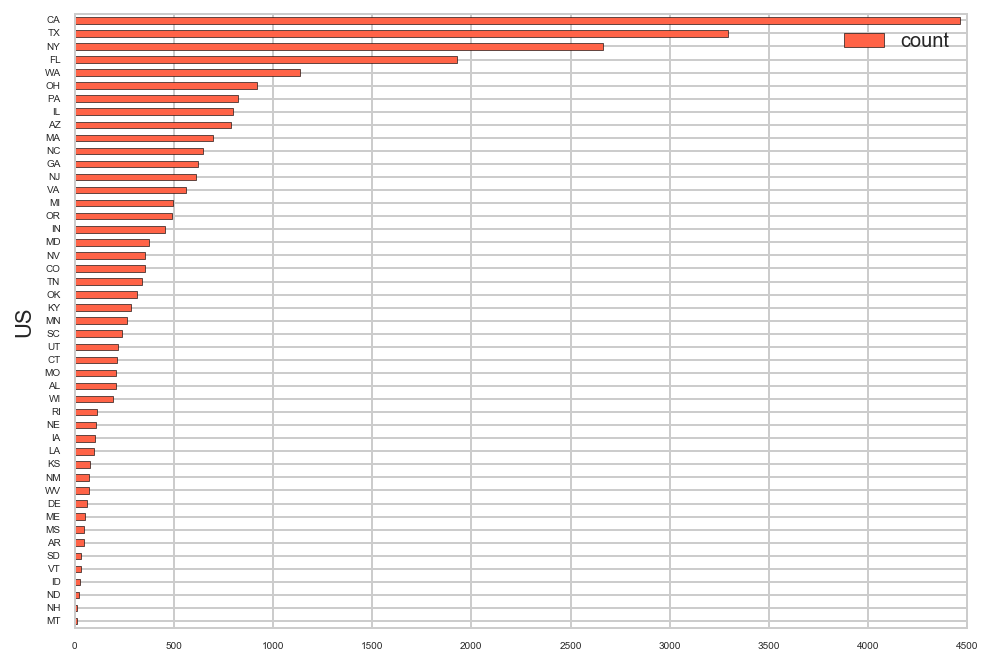

In [14]:
# Create the tweets counts from each state
poke_state = pd.DataFrame(df_US.groupby('US')['count'].sum(),
                         ).drop('NAN', axis = 0)
poke_state.sort_values(by='count', ascending =True).plot(kind='barh', color='tomato', fontsize=5)

In [15]:
# Analyze us population for each state
popu_url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population"
df_popu = pd.io.html.read_html(popu_url)[1]
df_popu.columns=df_popu.ix[0]
df_popu = df_popu[['State or territory', 'Percent of total U.S. pop., 2015[note 1]']]
df_popu.columns=['state','popu_percent']
df_popu.drop(0, axis=0, inplace=True)
df_popu.popu_percent = [float(x.split('%')[0]) for x in df_popu.popu_percent]
df_popu.head()
                  

,state,popu_percent
1,California,12.18
2,Texas,8.55
3,Florida,6.31
4,New York,6.16
5,Illinois,4.00


In [16]:
# Change state name to abbreviation
df_popu.state = [findstate(name.lower()).upper() for name in df_popu.state]
df_popu.head()

,state,popu_percent
1,CA,12.18
2,TX,8.55
3,FL,6.31
4,NY,6.16
5,IL,4.00


In [30]:
poke_state.columns=['poke_count']
df_poke = pd.merge(poke_state, df_popu,left_index=True, right_on='state')
df_poke.head()

,poke_count,state,popu_percent
24,211,AL,1.51
34,46,AR,0.93
14,790,AZ,2.12
1,4464,CA,12.18
22,356,CO,1.70


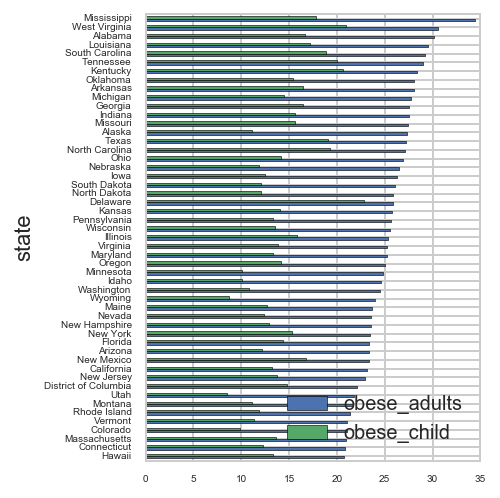

In [18]:
# Analyze percentage of obesity in US states
obesity_url= "https://en.wikipedia.org/wiki/Obesity_in_the_United_States"
df_obesity = pd.io.html.read_html(obesity_url)[0]
df_obesity.columns=['state','obese_adults','overweight_adults','obese_child','rank']
df_obesity.drop(0, axis = 0, inplace=True)
df_obesity.drop(['overweight_adults', 'rank'], axis=1, inplace=True)

# Convert string to float number
df_obesity.obese_adults = [float(d.strip('%')) for d in df_obesity.obese_adults]
df_obesity.obese_child = [float(d.strip('%')) for d in df_obesity.obese_child]

# Visuliaze
df_obesity.sort_values(by='obese_adults').plot(
    x= 'state', kind='barh', figsize=(3,4), fontsize=5)

In [19]:
# Change state name to abbreviation
df_obesity.state = [findstate(name.lower()).upper() for name in df_obesity.state]

In [31]:
# Combine obesity data with pokemon and population data
df_poke = pd.merge(df_poke, df_obesity, on='state')

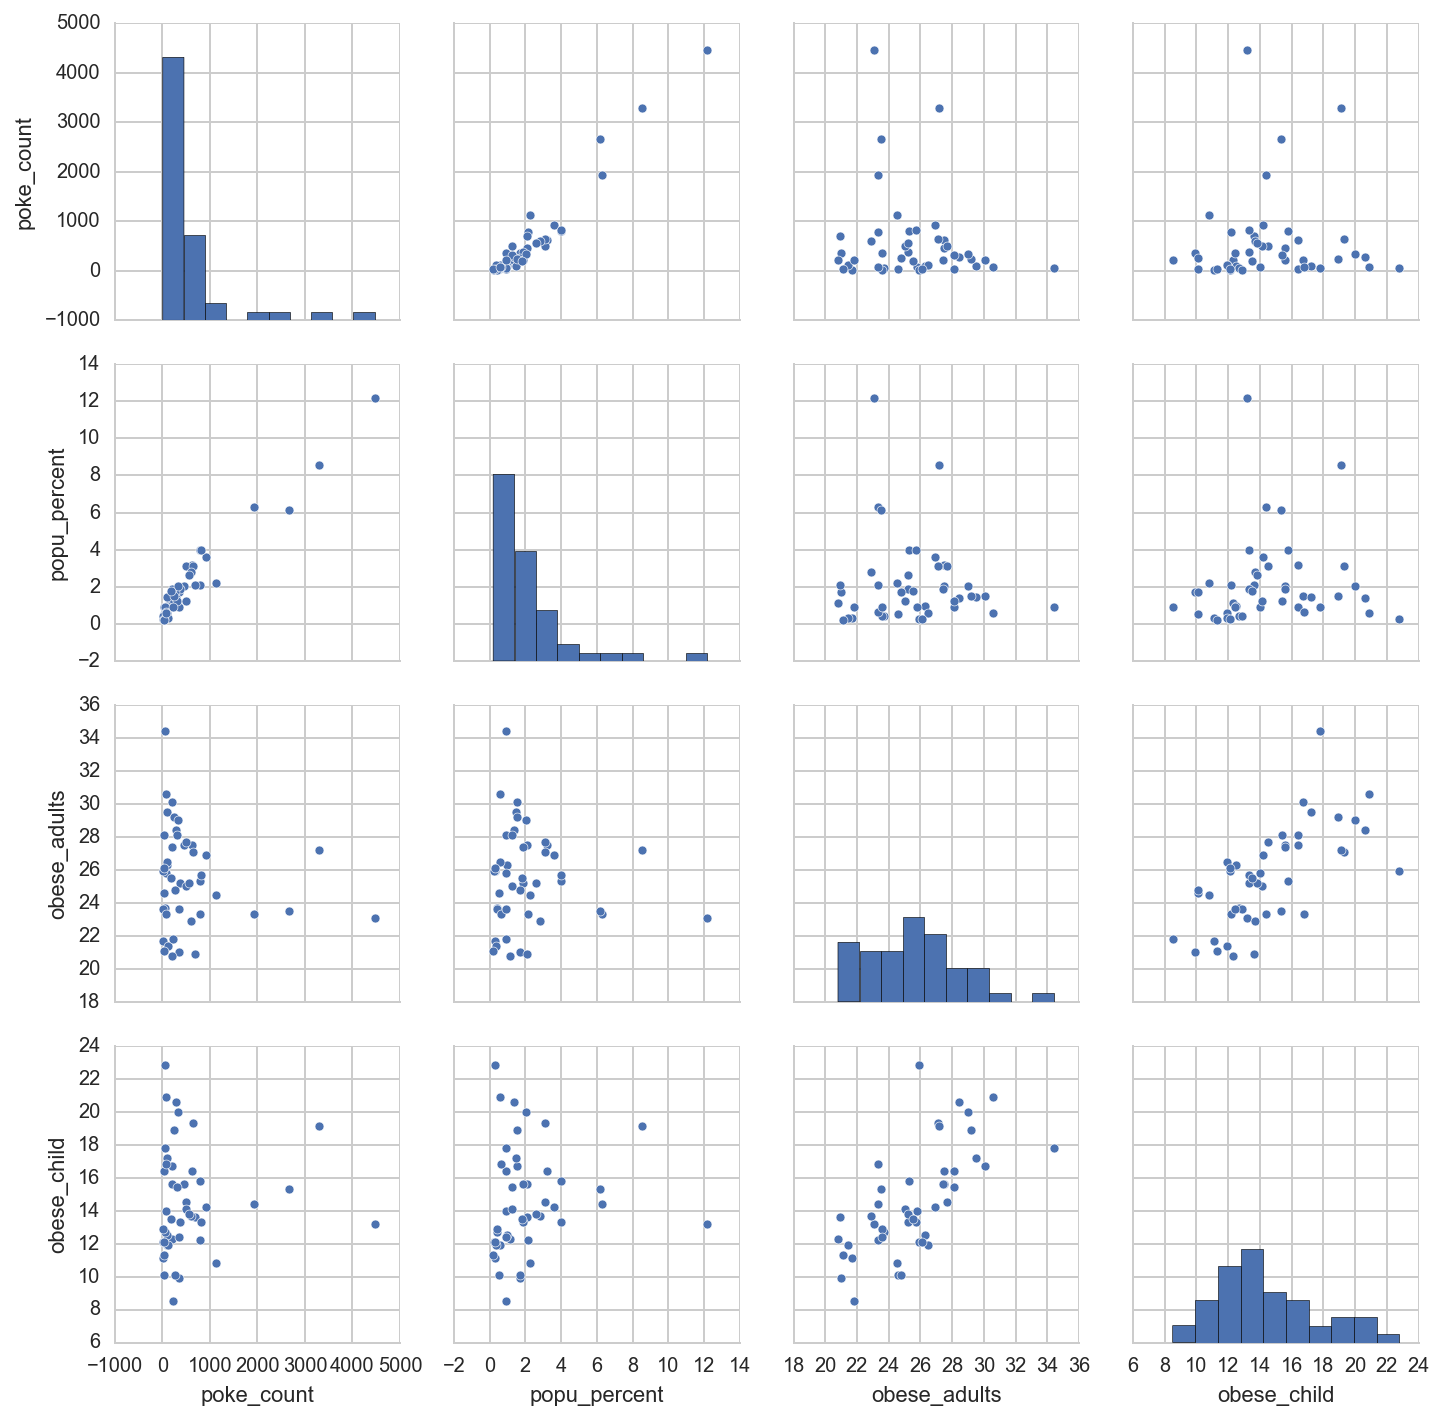

In [21]:
# correlation plot of state pokemon tweet counts, state population, state obesity percent
sns.pairplot(df_poke)

In [32]:
df_poke.head()

,poke_count,state,popu_percent,obese_adults,obese_child
0,211,AL,1.51,30.1,16.7
1,46,AR,0.93,28.1,16.4
2,790,AZ,2.12,23.3,12.2
3,4464,CA,12.18,23.1,13.2
4,356,CO,1.70,21.0,9.9


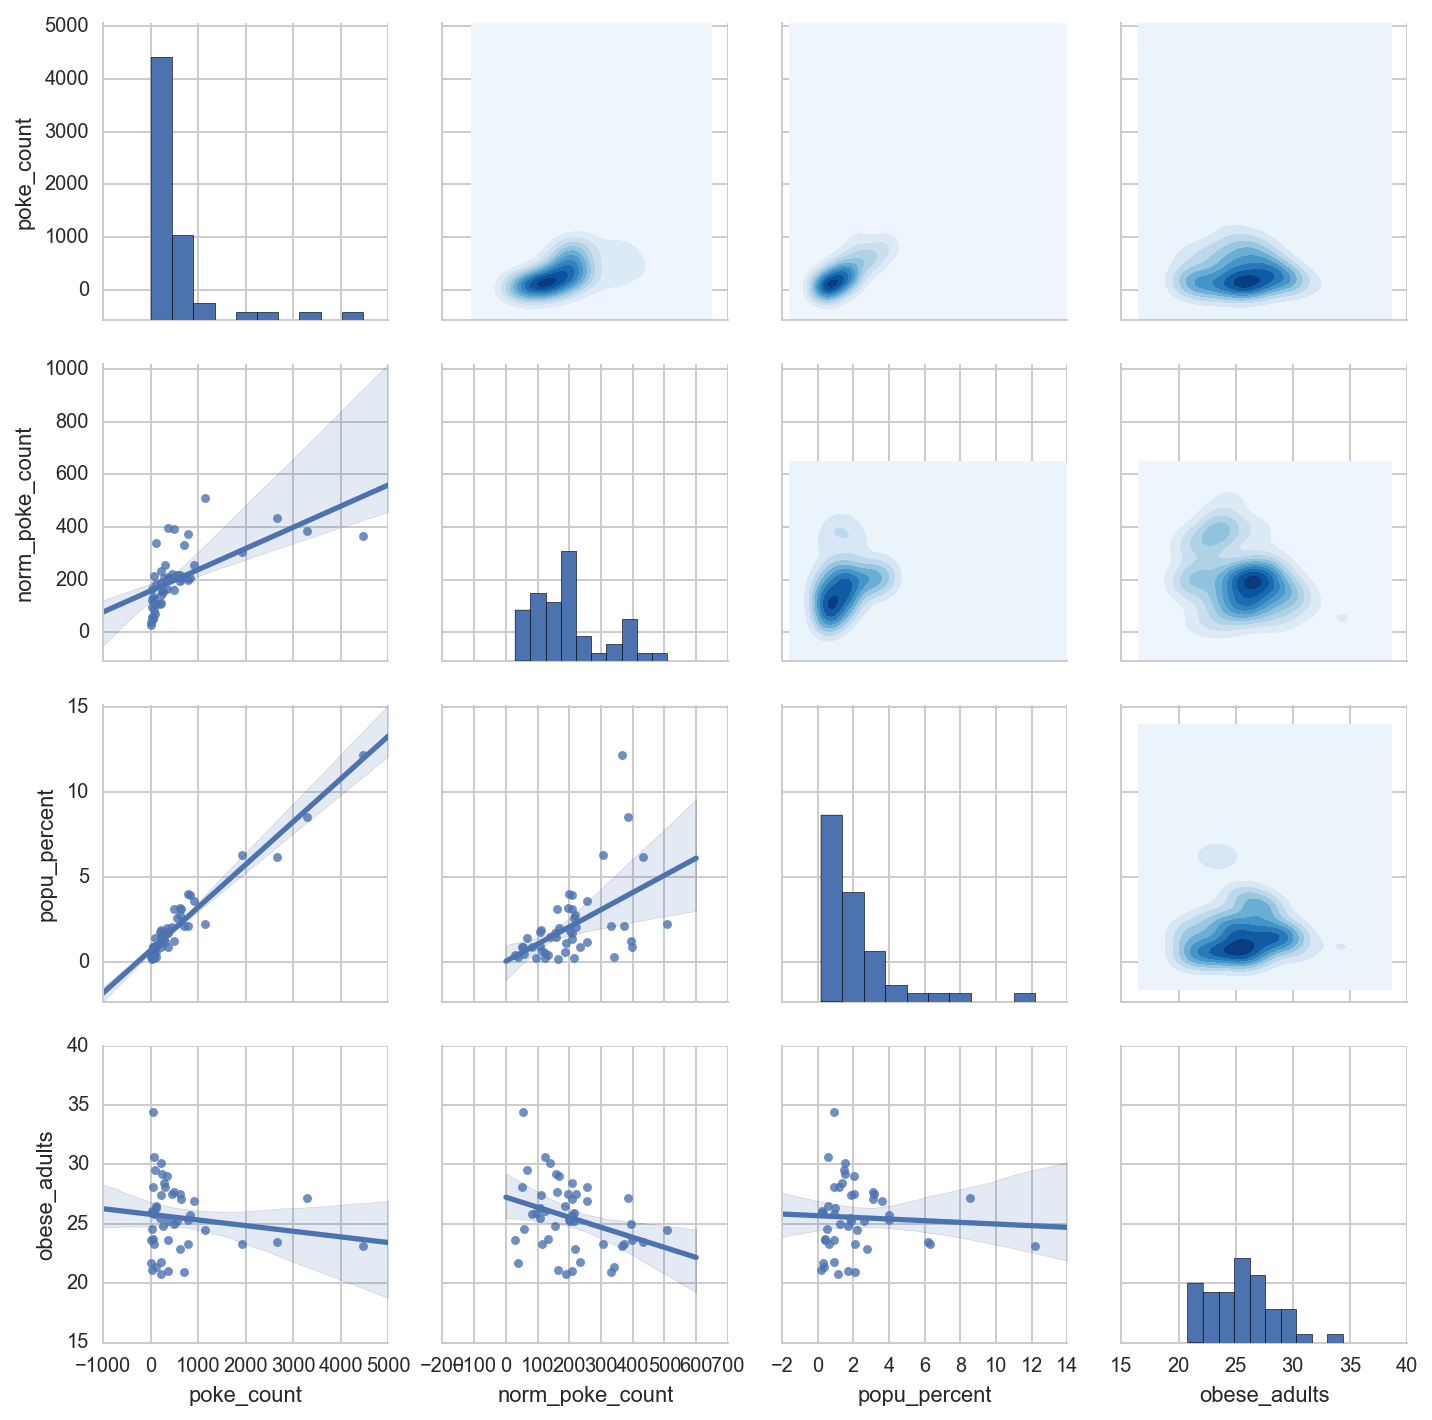

In [34]:
# Normalize the pokemon tweet counts by state population
df_poke['norm_poke_count'] = df_poke.poke_count / df_poke.popu_percent
g = sns.PairGrid(df_poke[['poke_count','norm_poke_count','popu_percent','obese_adults']])
g.map_lower(sns.regplot)
g.map_upper(sns.kdeplot, shade=True, cmap='Blues')
g.map_diag(plt.hist)


In [24]:
# Calculate the linear correlation coefficient between variables
np.corrcoef(df_poke.norm_poke, df_poke.obese_adults)

array([[ 1.        , -0.33104783],
       [-0.33104783,  1.        ]])

In [25]:
df_poke.head()

,poke_count,state,popu_percent,obese_adults,obese_child,norm_poke
0,211,AL,1.51,30.1,16.7,139.735099
1,46,AR,0.93,28.1,16.4,49.462366
2,790,AZ,2.12,23.3,12.2,372.641509
3,4464,CA,12.18,23.1,13.2,366.502463
4,356,CO,1.70,21.0,9.9,209.411765
